# Five-site tight-binding lattice and Anderson localization


Particle propagation is significantly impacted by the introduction of disorder in the on-site energies, leading to Anderson localization. Lattice inhomogeneity causes scattering and leads to quantum interference that tends to inhibit particle propagation, a signature of localization. The wavefunction of a localized particle rapidly decays away from its initial position, effectively confining the particle to a small region of the lattice.

Phillip Anderson first proposed that scattering from disorder can bring transport to a complete halt in 1958 [1]. Before Anderson's discovery, scientists modelled crystal disorders as perturbations that scatter electrons randomly, treating electrons as point-like particles. This logic led to the description of transport in such media as Brownian motion, which underlies Ohm's law. However, Anderson revisited the effect of disorder on the evolution of an electron's wavefunction in an otherwise periodic crystal [2]. 

Anderson analysed the problem in the quantum regime, thus fundamentally accounting for the wave nature of the electron, and found that the classical diffusive motion of the electron breaks down as the electronic wavefunction becomes exponentially localized, under a broad range of conditions. Hence, when the electron is initially placed on one atom, its wavefunction will no longer expand to cover the whole crystal with time, but it will rather remain localized around its initial position. Thus, the material will cease to conduct charge, and eventually become an insulator. This localization phenomenon is a direct consequence of interference between different paths arising from multiple scattering of the electron by lattice defects.

In the figure below you can see Anderson localization in a phtonic crystal. As the disorder gets increased, the light beam becomes exponentially localized.
![balanced1.png](Andersonlocalization.png)


In this exercise we look at a spin model with 5 sites. After considering a clean lattice, we add a disorder potential to investigate the phenomenon of Anderson localization.

[1] A. Lagendijk et al., *Fifty years of Anderson localization*, [ Physics Today 62, 8, 24 (2009)](https://physicstoday.scitation.org/doi/10.1063/1.3206091?feed=most-cited)

[2] M. Segev et al., *Anderson localization of light*, [Nature Photonics volume 7, pages 197–204 (2013)](https://www.nature.com/articles/nphoton.2013.30)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from qiskit_ibm_provider import IBMProvider
from qiskit_aer import AerSimulator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

As in exercise 5a, we use Trotter decomposition to simulate the time evolution of a spin system. In case you are not familiar with Trotter decomposition, you can read the introduction in Exercise 5a. As before we need the gates $XX(t)$ and $YY(t)$. The time $t$ denotes here the time for one trotter step.

$\color{red}{\text{Exercise 1: Construct the gates XX(t) and YY(t). If you have done Exercise 5a already, you can use the solutions from there. Otherwise you can follow the same steps.}}$

In [3]:
t = Parameter('t') #time parameter
#Your code goes here
# Build a subcircuit for ZZ(t) from single- and two-qubit gates

ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)
ZZ = ZZ_qc.to_instruction()


XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')
XX_qc.h(1)
XX_qc.h(0)
XX_qc.append(ZZ, [0,1])
XX_qc.h(1)
XX_qc.h(0)
XX = XX_qc.to_instruction()

YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')
YY_qc.sdg(1)
YY_qc.sdg(0)
YY_qc.h(1)
YY_qc.h(0)
YY_qc.append(ZZ, [0,1])
YY_qc.h(1)
YY_qc.h(0)
YY_qc.s(1)
YY_qc.s(0)
YY = YY_qc.to_instruction()

# 1. Five-site tight-binding lattice: 

In this exercise we simulate a lattice with five sites. First, we look at the tight-binding Hamiltonian with all the site energies at the same value. As a reminder, the Hamiltonian for a 5 site tight-binding lattice is: 

$$H/\hbar = J \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1})$$

Each term in the Hamiltonian describes the kinetic energy between nearest-neighbours spins. This spin Hamiltonian is [equivalent to free fermions hopping on a lattice](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation). The qubit state $|0\rangle$ means no fermion on the given site while $|1\rangle$ denotes one fermion ocuppying that site. Free fermions propagate as plane waves such that they move ballistically (i.e. $\Delta x \sim  \Delta t $ in average, where $\Delta x$ is the displacement during a time interval $\Delta t$). Our goal is to simulate the time evolution of fermions using qubits and check how a single fermion travles across the chain. 

For this challenge, without loss of generality, we set $\hbar=1$ and $J=1$.

$\color{red}{\text{Exercise 3: Create the Trotter step intruction. If you have done exercise 5, you can use the solution from this exercise.}}$

In [4]:
num_qubits = 5 

Trot_tb_qr = QuantumRegister(num_qubits)
Trot_tb_qc = QuantumCircuit(Trot_tb_qr, name='Trot')

#Your code goes here
for i in range(0, num_qubits - 1,2):#even qubits
    Trot_tb_qc.append(YY, [Trot_tb_qr[i], Trot_tb_qr[i+1]])
    Trot_tb_qc.append(XX, [Trot_tb_qr[i], Trot_tb_qr[i+1]])
for i in range(1, num_qubits - 1,2):#odd qubits
    Trot_tb_qc.append(YY, [Trot_tb_qr[i], Trot_tb_qr[i+1]])
    Trot_tb_qc.append(XX, [Trot_tb_qr[i], Trot_tb_qr[i+1]])




Trot_tb_gate = Trot_tb_qc.to_instruction() #Convert the circuit into a gate for later use

#Trot_tb_qc.draw()



Next, we want to add a particle in the form of an excitation to **qubit 0**. This can be accomplished by applying an  𝑋  gate to flip the state of the qubit from  |0⟩  to  |1⟩  before time evolution under the Hamiltonian.


$\color{red}{\text{Exercise 4: Excite qubit 0 of the chain}}$

In [5]:
delta_t=0.15 #one time step
time_steps=np.arange(0,20,1) #number of time steps

circuits=[]

qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)
qc.x(0) #excite the qubit 0
circuits.append(qc)
#Now we construct the circuit for the other time steps
for n_steps in time_steps[1:]:
    
    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr,cr)

    #Your code goes here
    qc.x(0)
    
    for _ in range(n_steps):
        qc.append(Trot_tb_gate, [i for i in range(num_qubits)]) #append the Trotter gate on the qubits 0...n-1
        
    qc = qc.bind_parameters({t: delta_t})
    
    circuits.append(qc)

We can track the movement of the particle by keeping track of the probability of finding the excitation on each qubit at different time steps. 

$\color{red}{\text{Exercise 5: Extract the probabilities of each qubit being in the $|1\rangle$ at different times using the output state from the statevector_simulator.}}$

Hint: create a small circuit *qctest* that only applies a Z gate at position i.
You can use then the instruction *a=Operator(qctest)* that converts this circuit into an operator. You can measure the expectation value for this operator applied to your state by the command *outputstate.expectation_value(a)* .

In [6]:
from qiskit import transpile
# Use Aer's statevector simulator
from qiskit import Aer
from qiskit.quantum_info.operators import Operator, Pauli
# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_density=[]
for circ in circuits:

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)#transpile the circuits

    job_sim = backend_sim.run(transpiled_circ)#run the circuits on a simulator

    # Grab the results from the job.
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    ps=[]
    #(Extract the probability of finding the excitation on each qubit)
    #Your code goes here 
    for i in range(num_qubits):
      qtest = QuantumRegister(num_qubits)
      qctest = QuantumCircuit(qtest)
      qctest.z(i)
      a=Operator(qctest)
      ps.append(np.real(1/2*(1-outputstate.expectation_value(a))))

    probability_density.append(ps)
    
probability_density=np.array(probability_density)

We can now plot the time evolution of the excitation. What can you see?

Text(0, 0.5, 'Time (1/J)')

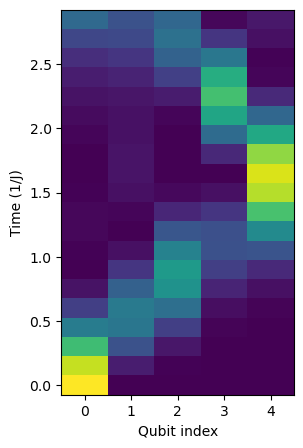

In [7]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t, probability_density)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

<b>Run the same circuit now on a quantum computer</b> 
    
Run the circuits on real hardware and extract the probability of finding an excitation on each qubit.
    
</div>

In [10]:
from qiskit.tools.monitor import job_monitor
IBMProvider.save_account("740cf9a029345b5770ad72af52ca4d1c51eb8afe78c6d95e17ecffd2e72033a693cf8563418f2143cf5d9780f497e3100577f0a400d882f5d4314ca68ce9fc37",overwrite=True)
provider = IBMProvider()
backend = provider.get_backend('ibm_perth')
backend2= AerSimulator.from_backend(backend)
backendsim = AerSimulator()

We can use the circuits defined above and run the machines on a quantum device.

In [11]:
initial_layout=[0 , 1 , 3 , 5 , 4] #The mapping of qubits in our circuits to the physical qubits of the device. In this case we do it manually to improve the results. For more details, see Exercise 1c.

hardware_transpiled_circuits=[]
for circ in circuits:
    
    hardware_circ=deepcopy(circ) #Create a copy of the circuits
    hardware_circ.barrier()
    hardware_circ.measure(range(num_qubits), range(num_qubits)) #Add a measurment to the circuits
    hardware_transpiled_circuits.append(transpile(hardware_circ, backend2, initial_layout=initial_layout, optimization_level=3)) #change the backend form backend to backend2, if its too slow.

In [12]:
shots=1024 #number of measurements
#Execute the circuits on the device
job = execute(hardware_transpiled_circuits, backend=backend2, shots=shots) #replace backedn by backend2 if necessary
job_monitor(job)
print('Job ID', job.job_id())

Job Status: job has successfully run
Job ID 7f8be476-a647-4be7-9404-3b08a479a7be


$\color{red}{\text{Exercise 6: Extract the probabilities of each qubit being in the $|1\rangle$ at different times using the results.}}$

Hint: *np.fromstring(keys,'u1') - ord('0')* gives you the bitstring of each measurment output as an array.

In [13]:
experiment_results=job.result()

probability_density_exp=[]
for output in experiment_results.get_counts():
    ps=np.zeros(num_qubits)
    #Your code goes here
    for keys in output:
      ps+=output[keys]/1024*(np.fromstring(keys,'u1') - ord('0'))
    probability_density_exp.append(ps[::-1]) #append the excitation pattern to your output array


We can compare the result on the real device circuit with the noiseless simulation. What do you observe?

Text(0, 0.5, 'Time (1/J)')

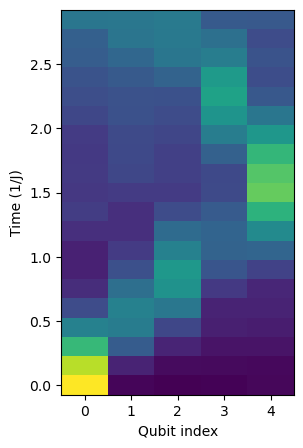

In [16]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(num_qubits), time_steps*delta_t, probability_density_exp)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

## 2. Disorder on: Anderson localization

We can study Anderson localization using the tight-binding Hamiltonian. The Hamltonian in the presence of disorder in site energies takes the following form: 
$$H/\hbar = \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1}) + \sum_{i=0}^{4} \epsilon_i Z_i $$

By changing the $\epsilon_i$ values we can imitate disorder by creating an Aubry-Andre (AA) quasicrystal which leads to Anderson localization. In this lattice model, $\epsilon_i=W \rm{cos}(2\pi\beta i)$ where $W$ is the disorder strength, and $\beta$ determines the quasicrystal periodicity.

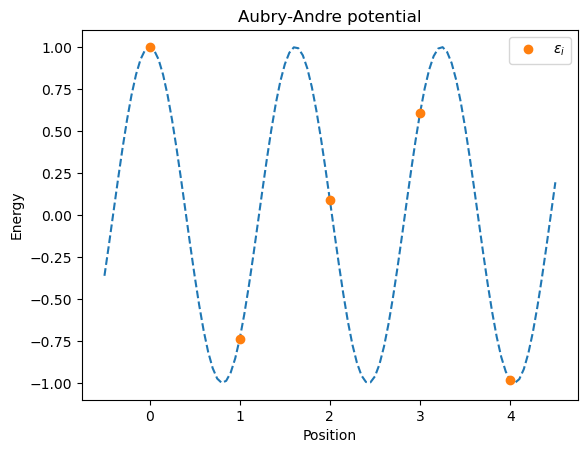

In [17]:
beta=(np.sqrt(5)-1)/2 #By choosing the golden ratio for the paprameter beta, the potential looks maximally chaotic
AA_patern=np.cos(2*np.pi*beta*np.arange(num_qubits)) #This will be our disorder pattern in the following exercise

plt.plot(np.linspace(-0.5,4.5,101), np.cos(2*np.pi*beta*np.linspace(-0.5,4.5,101)), '--')
plt.plot(np.arange(num_qubits), AA_patern, 'o', label=r'$\epsilon_i$')
plt.xlabel('Position')
plt.ylabel('Energy')
plt.legend()
plt.title('Aubry-Andre potential')
plt.show()

We can include the disorder easily into our Trotter ccircuits: To do so, we add a phase gate of the form *Trot_qc_disorder.p(deltas[i], i)* to our Trotter circuit. The phase corresponds to the disorder potential and has to be (pseudo-)random at each site


$\color{red}{\text{Exercise 7: Modify each tight-binding trotter step to include an arbitrary phase used to simulate Anderson localization.}}$


In [18]:
Trot_qr_disorder = QuantumRegister(num_qubits)
Trot_qc_disorder = QuantumCircuit(Trot_qr_disorder, name='Trot disorder')

Trot_qc_disorder.append(Trot_tb_gate,[0,1,2,3,4])
deltas=[Parameter('delta_{:d}'.format(idx)) for idx in range(num_qubits)]#The random phase for each qubit
print(deltas)

###Your code goes here
for i in range(num_qubits):
  Trot_qc_disorder.p(deltas[i], i)

# Convert custom quantum circuit into a gate
Trot_disorder_gate = Trot_qc_disorder.to_instruction()

Trot_qc_disorder.draw()

[Parameter(delta_0), Parameter(delta_1), Parameter(delta_2), Parameter(delta_3), Parameter(delta_4)]


┌──────────┐┌────────────┐
q394_0: ┤0         ├┤ P(delta_0) ├
        │          │├────────────┤
q394_1: ┤1         ├┤ P(delta_1) ├
        │          │├────────────┤
q394_2: ┤2 Trot(t) ├┤ P(delta_2) ├
        │          │├────────────┤
q394_3: ┤3         ├┤ P(delta_3) ├
        │          │├────────────┤
q394_4: ┤4         ├┤ P(delta_4) ├
        └──────────┘└────────────┘

Now we can construct again our circuit for each time step.

In [19]:
delta_t=0.15
time_steps=np.arange(1,20,1)

W=2 #Disorder strength, you can play later with it

disorders=W*AA_patern # DO NOT EDIT

disorder_circuits=[]

for n_steps in time_steps:

    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr, cr)

    qc.x(0)
    
    for _ in range(n_steps):
        qc.append(Trot_disorder_gate, [i for i in range(num_qubits)])

    qc = qc.bind_parameters({t: delta_t})
    qc = qc.bind_parameters({deltas[idx]: disorders[idx] for idx in range(num_qubits)})

    disorder_circuits.append(qc)

$\color{red}{\text{Exercise 8: Extract the probability of finding an excitation on each qubit, you can use the solution of exercise 5}}$

In [20]:
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_density_localization=[]
for circ in disorder_circuits:

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Grab the results from the job.
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    ps=[]
    #Your code goes here
    for i in range(num_qubits):
      qtest = QuantumRegister(num_qubits)
      qctest = QuantumCircuit(qtest)
      qctest.z(i)
      a=Operator(qctest)
      ps.append(np.real(1/2*(1-outputstate.expectation_value(a))))

    #append the excitation density to your result
    probability_density_localization.append(ps)
    
probability_density_localization=np.array(probability_density_localization)

Plot now the results with disorder. What can you see in comparison to the case before?

Text(0, 0.5, 'Time (1/J)')

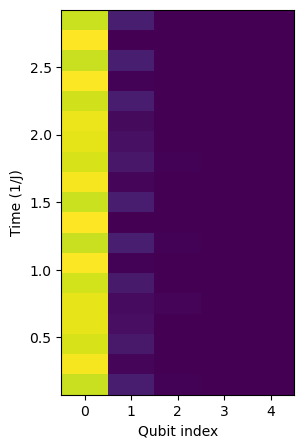

In [21]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t ,probability_density_localization)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

<b>Run the same circuit now on a quantum computer</b> 
    
First we have to transpile the circuits again.
    
</div>

In [22]:
initial_layout=[0 , 1 , 3 , 5 , 4] #The mapping of qubits in our circuits to the physical qubits of the device. In this case we do it manually to improve the results. For more details, see Exercise 1c.

hardware_transpiled_circuits_disordered=[]
for circ in disorder_circuits:
    
    hardware_circ=deepcopy(circ)
    hardware_circ.barrier()
    hardware_circ.measure(range(num_qubits), range(num_qubits)) #append a measurement
    hardware_transpiled_circuits_disordered.append(transpile(hardware_circ, backend, initial_layout=initial_layout, optimization_level=3)) #transpile your circuits

Now execute the circuits on a quantum computer.

In [23]:
shots=1024
job_disorder = execute(hardware_transpiled_circuits_disordered, backend=backend2, shots=shots) #replace backend by backend2 in case you do not want to wait that long
job_monitor(job_disorder)
print('Job ID', job_disorder.job_id())

Job Status: job has successfully run
Job ID cab5dc37-8e65-4a70-b8f0-b8c095c15da4


$\color{red}{\text{Exercise 9: Extract the probabilities of each qubit being in the $|1\rangle$ at different times using the results (same as exercise 6).}}$

In [24]:
disorder_experiment_results=job_disorder.result()

disorder_probability_density_exp=[]
for output in disorder_experiment_results.get_counts():
    ps=np.zeros(num_qubits)
    #Your code goes here
    for keys in output:
      ps+=output[keys]/1024*(np.fromstring(keys,'u1') - ord('0'))

    disorder_probability_density_exp.append(ps[::-1])
    

Finally we can plot the result again and compare with real hardware.

Text(0, 0.5, 'Time (1/J)')

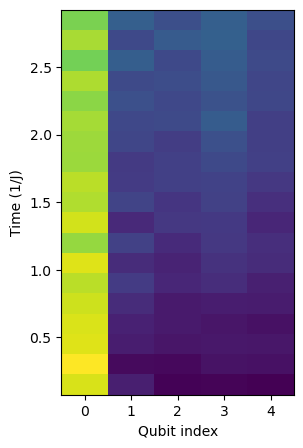

In [26]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(num_qubits), time_steps*delta_t, disorder_probability_density_exp)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

These notebooks are comprised of text and code taken from Qiskit's [documentation](https://qiskit.org/documentation/), [tutorials](https://qiskit.org/documentation/tutorials.html#quantum-circuits), [textbook](https://qiskit.org/textbook/preface.html), and previous challenges facilitated by Qiskit.